In [14]:
#import
import tensorflow as tf
from tensorflow import keras
import os
import random
import math

#import helper libraries
import numpy as np
import matplotlib.pyplot as pyplot
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

print(tf.__version__)

2.1.0


In [15]:
#Testing mean and std deviation of numpy
arr = np.array([[1, 2, 3, 4, 5]])
mean = np.mean(arr)
std = np.std(arr)
mean, std

(3.0, 1.4142135623730951)

In [16]:
# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

In [17]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model() 
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		#history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=1)
		history = fit_model(model)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [18]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [19]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

In [20]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
	trainX, trainY, testX, testY = load_dataset()
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	print('evaluate model completed')
	print('scores=',scores,'  histories=',histories)
	# learning curves
	##summarize_diagnostics(histories)????
	##print('learning cureve completed')????
	# summarize estimated performance
	summarize_performance(scores)
	print('performance score completed')


In [21]:
def load_dataset():
    #import dataset
    mnist = keras.datasets.mnist
    #load dataset
    (trainX, trainY),(testX,testY) = mnist.load_data()
    # Normalize the input image so that each pixel value is between 0 to 1.
    trainX = trainX / 255.0
    testX = testX / 255.0
    print('Pixels are normalized')
    return trainX, trainY, testX, testY

In [22]:
# np.set_printoptions(linewidth = 200)
# plt.imshow(trainX[7])
# print(trainY[7])
# print(trainX[7])

Pixels are normalized


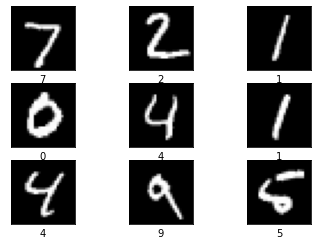

In [23]:
#Plot first few images
# load dataset
trainX, trainY, testX, testY = load_dataset()
for i in range(9):
    #define a subplot
    pyplot.subplot(3,3, i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    #plot raw pixel data
    pyplot.imshow(testX[i],cmap=pyplot.get_cmap('gray')) 
    pyplot.xlabel(testY[i])
#show the figures
pyplot.show()

In [31]:
def define_model():   
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(28, 28)),
        keras.layers.Reshape(target_shape=(28, 28, 1)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [32]:
#fit model
def fit_model(model):
    class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<1.5):
          print("\nReached 80% accuracy so cancelling training!")
          self.model.stop_training = True
    callbacks = myCallback()    
    history = model.fit(trainX, trainY, batch_size=32, epochs=5, validation_data=(testX, testY), callbacks=[callbacks])   
    return history

In [ ]:
# entry point, run the test harness
run_test_harness()

Pixels are normalized
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 231s 4ms/sample - loss: 1.6066 - accuracy: 0.8594 - val_loss: 1.5075 - val_accuracy: 0.9550
Epoch 2/5
60000/60000 [==============================] - 246s 4ms/sample - loss: 1.5204 - accuracy: 0.9419 - val_loss: 1.4955 - val_accuracy: 0.9657
Epoch 3/5
60000/60000 [==============================] - 211s 4ms/sample - loss: 1.5076 - accuracy: 0.9541 - val_loss: 1.4892 - val_accuracy: 0.9723
Epoch 4/5
60000/60000 [==============================] - 203s 3ms/sample - loss: 1.5009 - accuracy: 0.9606 - val_loss: 1.4819 - val_accuracy: 0.9800
Epoch 5/5
59968/60000 [============================>.] - ETA: 0s - loss: 1.4966 - accuracy: 0.9649
Reached 80% accuracy so cancelling training!
60000/60000 [==============================] - 207s 3ms/sample - loss: 1.4966 - accuracy: 0.9650 - val_loss: 1.4844 - val_accuracy: 0.9767
> 97.733
Train on 60000 samples, validate on 1000

In [ ]:
# Evaluating Keras model
model = define_model()
history= fit_model(model)
print('history',history)
score = model.evaluate(testX,testY, verbose=1)
print('score', score)

In [ ]:
#Predict the all label probabilities for the given test dataset
probability = model.predict(testX)
#print out all the 10-class probabilities of figure #6. Notes:class #4 has the highest
print(probability[7])
#predict the classes for the given test dataset
classifications = model.predict_classes(testX)
#print out the class of figture #6
print(classifications[7])

In [ ]:
#list all file with .png in the current working directory
os.listdir()

In [ ]:
# load the image with either 2 commands below. add param: target_size = (28,28),if there is only 1 images
#img = keras.preprocessing.image.load_img("MNIST_samples.png", color_mode = "grayscale", interpolation='bilinear')
img = load_img("MNIST_samples.png", color_mode = "grayscale", interpolation='bilinear')

In [ ]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
#plt.axis('off')
plt.imshow(img)
plt.show()

In [ ]:
# load the image
img = keras.preprocessing.image.load_img("1.png", color_mode = "grayscale", target_size = (28,28), interpolation='bilinear')
# prepare pixel data
img = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, 0)
# convert to array
img = img_to_array(img)
#reshape into a single sample with 1 channel
img = img.reshape(1,28,28)

In [ ]:
classifications = model.predict_classes(img)
print(classifications[0])

In [ ]:
# Download a test image
zero_img_path = keras.utils.get_file(
    'zero.png', 
    'https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/zero.png'
)

image = keras.preprocessing.image.load_img(
    zero_img_path,
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
)

plt.grid(False)
plt.gray()
#plt.axis('off')
plt.imshow(image)
plt.show()

In [ ]:
# Pre-process the image: Adding batch dimension and normalize the pixel value to [0..1]
# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 28, 28).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 28, 28) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

classifications = model.predict_classes(input_image)
print('Digit classification = ', classifications[0])

In [ ]:
#path = /users/andrew/AI_projects/ and name = digitpredict.h5
keras_file = "/users/andrew/AI_projects/digitpredict.h5"
#same the model
keras.models.save_model(model,keras_file)
#below statement would do the same as above but it's not clear to user
#model.save('/users/andrew/AI_projects/digitpredict.h5')

In [ ]:
#convert Keras file to Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save Tensorflow Lite model as "digitpredict.tflite" in the current directory
f = open("digitpredict.tflite","wb")
f.write(tflite_model)
f.close()

#show TF Lite model in KBs
tflite_model_size = len(tflite_model)/1024
print('Float model size = %dKBs.' % tflite_model_size)

In [ ]:
#Make the model smaller using Quantization for deploying to mobile device
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

#save Tensorflowquantized model as "digitpredict_quantized.tflite" in the current directory
f = open("digitpredict_quantized.tflite","wb")
f.write(tflite_quantized_model)
f.close()


# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the tflite_model_size.'\
      % (quantized_model_size * 100 / tflite_model_size))

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(testX)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)
print('length', len(prediction_digits))

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18,18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(testX[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],testY[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

In [ ]:
#Evaluate the TF Lite model
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in testX:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == testY[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_model)
print('tflite model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

In [ ]:
# Download the digit classification model if you're using Colab, 
# or print the model's local path if you're not using Colab.
try:
  from google.colab import files
  files.download('digitpredict_quantized.tflite')
except ImportError:
  import os
  print('TF Lite model:', os.path.join(os.getcwd(), 'digitpredict_quantized.tflite'))

In [ ]:
# Download a test image
zero_img_path = keras.utils.get_file(
    'zero.png', 
    'https://storage.googleapis.com/khanhlvg-public.appspot.com/digit-classifier/zero.png'
)
image = keras.preprocessing.image.load_img(
    zero_img_path,
    color_mode = 'grayscale',
    target_size=(28, 28),
    interpolation='bilinear'
)

# Pre-process the image: Adding batch dimension and normalize the pixel value to [0..1]
# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 28, 28).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 28, 28) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, 0)

# Show the pre-processed input image
show_sample(input_image, ['Input Image'], 1)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quantized_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0]

# Print the model's classification result
digit = np.argmax(output)
print('Predicted Digit: %d\nConfidence: %f' % (digit, output[digit]))

End !!!